# 15 Permintaan Analisis dari User
(Meidina)
1. “Ada laporan dari finance katanya total_amount gak selalu sama kayak harga dikali quantity. Tolong dicek ya, kira-kira kenapa bisa gitu.”
2. “Gue pengin tahu siapa aja customer yang paling sering belanja selama 6 bulan terakhir. Bisa di-rank dari yang paling aktif?”
3. “Kira-kira kota mana aja yang paling rame transaksi-nya dan yang paling gede omset-nya?”
(Sigit)
4. “Tolong lihat deh, produk apa yang paling sering dibatalin pengirimannya. Takutnya ada masalah di kategori tertentu.”
5. “Merchant mana yang perform-nya paling bagus dan yang paling jelek, kalau kita lihat dari jumlah transaksi sama total sales?”
6. “Kayaknya ada harga produk yang gak masuk akal. Bisa dicek produk-produk dengan harga ekstrem, entah terlalu murah atau mahal banget?”
(Salsa)
7. “Tolong bantu breakdown juga metode pembayaran yang paling sering dipakai di tiap kota. Gue pengin tahu preferensi pengguna di daerah.”
8. “Gue mau lihat seberapa banyak transaksi yang gagal dikirim (entah dibatalin atau dikembalikan). Bisa dibikinin persentasenya?”
9. “Kalau kita bandingin metode pembayaran sama status pengiriman, ada pola tertentu gak? Misalnya COD lebih sering gagal atau enggak.”
(Dede)
10. “Tolong buatkan grafik tren transaksi per minggu ya. Gue pengin lihat kira-kira kapan volume transaksi lagi tinggi-tingginya.”
11. “Bisa gak lo kelompokin pelanggan berdasarkan total belanja mereka? Misalnya low spender, medium, sama high spender gitu.”
12. “Coba analisis deh, apakah 10% pelanggan teratas kita beneran nyumbang mayoritas revenue kayak teori pareto itu?”

13. “Terakhir, coba lo gali insight menarik dari data ini deh. Gak harus sesuai request gue, tapi hal-hal yang menurut lo penting buat bisnis.”


In [92]:
import unittest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import io
import sys
from unittest.mock import patch
from IPython.display import display

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [93]:
df = pd.read_csv('belanjakita.csv')
df.head()

,transaction_id,transaction_date,customer_name,customer_city,product_category,product_name,unit_price,quantity,total_amount,payment_method,delivery_status,merchant_name
0,TRX-10001,2025-06-11,ANDI SAPUTRA,surabaya,fashion,Kaos Polos,6473388,10,64733880.0,Ewallet,Delivered,BeautyHub
1,TRX-10002,21-03-2025,Andi Saputra,jakarta,Fashion,Laptop Asus,2284489,1,2284489.0,Card,delivered,GadgetMart
2,TRX-10003,14/05/2025,NANDA PRATAMA,Surabaya,aksesoris,Vacuum Cleaner,9574682,10,95746820.0,COD,Pending,SportMax
3,TRX-10004,2025/06/25,Budi Santoso,Medan,Kecantican,Lipstik Wardah,9678519,10,96785190.0,Card,Returned,BeautyHub
4,TRX-10005,2025-07-09,Mega Putri,NaN,Acsesoris,Laptop Asus,4573669,2,9147338.0,Transfer,NaN,TrendShop


# Cleaning dataset

In [94]:
# Buat copy dataframe untuk cleaning
df = belanja.copy()

# Cek info dataset terlebih dahulu
print("=== INFO DATASET ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
df.head()
print(f"\nData types:")
df.dtypes

=== INFO DATASET ===
Shape: (5000, 14)
Columns: ['transaction_id', 'transaction_date', 'customer_name', 'customer_city', 'product_category', 'product_name', 'unit_price', 'quantity', 'total_amount', 'payment_method', 'delivery_status', 'merchant_name', 'calculated_total', 'amount_difference']

Sample data:

Data types:


transaction_id        object
transaction_date      object
customer_name         object
customer_city         object
product_category      object
product_name          object
unit_price             int64
quantity               int64
total_amount         float64
payment_method        object
delivery_status       object
merchant_name         object
calculated_total       int64
amount_difference    float64
dtype: object

In [95]:
# Cek format tanggal yang ada
if 'transaction_date' in df.columns:
    print(df['transaction_date'].head(10).tolist())
    
    # Baca ulang dari CSV untuk mendapatkan format asli
    df_temp = pd.read_csv('belanjakita.csv')
    print(df_temp['transaction_date'].head(10).tolist())
    
    # Fungsi untuk parse berbagai format tanggal
    def parse_date(date_str):
        if pd.isna(date_str) or str(date_str).lower() in ['nan', 'null', '']:
            return pd.NaT
        
        date_str = str(date_str).strip()
        
        # Daftar format tanggal yang mungkin
        date_formats = [
            '%d-%m-%Y',    # 01-12-2023
            '%d/%m/%Y',    # 01/12/2023
            '%d.%m.%Y',    # 01.12.2023
            '%Y-%m-%d',    # 2023-12-01
            '%Y/%m/%d',    # 2023/12/01
            '%m-%d-%Y',    # 12-01-2023
            '%m/%d/%Y',    # 12/01/2023
            '%d-%m-%y',    # 01-12-23
            '%d/%m/%y',    # 01/12/23
            '%Y-%m-%d %H:%M:%S',
            '%d-%m-%Y %H:%M:%S',
            '%d/%m/%Y %H:%M:%S'
        ]
        
        for fmt in date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        
        # Jika semua format gagal, coba dengan pandas inference
        try:
            return pd.to_datetime(date_str, dayfirst=True)
        except:
            try:
                return pd.to_datetime(date_str, dayfirst=False)
            except:
                return pd.NaT
    
    # Apply fungsi parsing
    print("\nMembersihkan format tanggal...")
    df['transaction_date'] = df_temp['transaction_date'].apply(parse_date)
    
    # Cek hasil
    valid_dates = df['transaction_date'].notna().sum()
    total_dates = len(df)
    success_rate = (valid_dates / total_dates) * 100
    
    print(f"Berhasil diparse: {valid_dates:,} dari {total_dates:,} ({success_rate:.1f}%)")
    print(f"Tanggal gagal diparse: {df['transaction_date'].isna().sum():,}")
    
    if valid_dates > 0:
        print(f"Range tanggal: {df['transaction_date'].min()} hingga {df['transaction_date'].max()}")
        print("\nSample tanggal setelah cleaning:")
        print(df['transaction_date'].dropna().head(10).tolist())
    
else:
    print("Kolom transaction_date tidak ditemukan!")

['2025-06-11', '21-03-2025', '14/05/2025', '2025/06/25', '2025-07-09', '2025/03/02', '2025/07/08', '08/08/2025', '2025/05/28', '2025/03/15']
['2025-06-11', '21-03-2025', '14/05/2025', '2025/06/25', '2025-07-09', '2025/03/02', '2025/07/08', '08/08/2025', '2025/05/28', '2025/03/15']

Membersihkan format tanggal...
Berhasil diparse: 5,000 dari 5,000 (100.0%)
Tanggal gagal diparse: 0
Range tanggal: 2025-03-01 00:00:00 hingga 2025-08-27 00:00:00

Sample tanggal setelah cleaning:
[Timestamp('2025-06-11 00:00:00'), Timestamp('2025-03-21 00:00:00'), Timestamp('2025-05-14 00:00:00'), Timestamp('2025-06-25 00:00:00'), Timestamp('2025-07-09 00:00:00'), Timestamp('2025-03-02 00:00:00'), Timestamp('2025-07-08 00:00:00'), Timestamp('2025-08-08 00:00:00'), Timestamp('2025-05-28 00:00:00'), Timestamp('2025-03-15 00:00:00')]


In [96]:
df

,transaction_id,transaction_date,customer_name,customer_city,product_category,product_name,unit_price,quantity,total_amount,payment_method,delivery_status,merchant_name,calculated_total,amount_difference
0,TRX-10001,2025-06-11,ANDI SAPUTRA,surabaya,fashion,Kaos Polos,6473388,10,64733880.0,Ewallet,Delivered,BeautyHub,64733880,0.0
1,TRX-10002,2025-03-21,Andi Saputra,jakarta,Fashion,Laptop Asus,2284489,1,2284489.0,Card,delivered,GadgetMart,2284489,0.0
2,TRX-10003,2025-05-14,NANDA PRATAMA,Surabaya,aksesoris,Vacuum Cleaner,9574682,10,95746820.0,COD,Pending,SportMax,95746820,0.0
3,TRX-10004,2025-06-25,Budi Santoso,Medan,Kecantican,Lipstik Wardah,9678519,10,96785190.0,Card,Returned,BeautyHub,96785190,0.0
4,TRX-10005,2025-07-09,Mega Putri,NaN,Acsesoris,Laptop Asus,4573669,2,9147338.0,Transfer,NaN,TrendShop,9147338,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,TRX-14996,2025-08-19,RUDI HARTONO,Yogyekerte,Electronic,Powerbank 10K,2036952,5,10184760.0,Ewallet,Delivered,GadgetMart,10184760,0.0
4996,TRX-14997,2025-08-01,Dewi Lestari,NaN,Olahragas,Sepatu Nike,9716360,2,19432720.0,COD,Returned,SportMax,19432720,0.0
4997,TRX-14998,2025-03-16,Siti Aminah,Makassar,Olahraga,Powerbank 10K,2234996,10,22349960.0,Kartu Kredit,Returned,TechZone,22349960,0.0
4998,TRX-14999,2025-03-26,SITI AMINAH,Jekerte,elektronik,Headphone JBL,9957731,15,149365965.0,Kartu Kredit,delivered,HomeEssence,149365965,0.0


In [97]:
# Mapping untuk product_category
mapping_kategori = {
    'Ascesoris': 'Aksesoris',
    'aksesoris': 'Aksesoris',
    'Aksesoris': 'Aksesoris',
    'Electronic': 'Elektronik',
    'elektronik': 'Elektronik',
    'Elektroniks': 'Elektronik',
    'fashion': 'Fashion',
    'Fashions': 'Fashion',
    'Kecantican': 'Kecantikan',
    'kecantikan': 'Kecantikan',
    'Kecantikans': 'Kecantikan',
    'Macanan': 'Makanan',
    'Makanan': 'Makanan',
    'Makanans': 'Makanan',
    'olahraga': 'Olahraga',
    'Olahragas': 'Olahraga',
    'rumah tangga': 'Rumah Tangga',
    'Rumah Tanggas': 'Rumah Tangga'
}

# Mapping untuk customer_city
mapping_kota = {
    'Ban': 'Bandung',
    'Bandung': 'Bandung',
    'Bendung': 'Bandung',
    'Den': 'Denpasar',
    'Denpasar': 'Denpasar',
    'Denpeser': 'Denpasar',
    'Jak': 'Jakarta',
    'jakarta': 'Jakarta',
    'Jekerte': 'Jakarta',
    'Mak': 'Makassar',
    'makassar': 'Makassar',
    'Mekesser': 'Makassar',
    'Med': 'Medan',
    'Medan': 'Medan',
    'Meden': 'Medan',
    'Sur': 'Surabaya',
    'surabaya': 'Surabaya',
    'Surebeye': 'Surabaya',
    'Yog': 'Yogyakarta',
    'Yogyakarta': 'Yogyakarta',
    'Yogyekerte': 'Yogyakarta',
    'NaN': 'Unknown',
    '': 'Unknown'
}

# Mapping untuk delivery_status
mapping_delivery_status = {
    'Canceled': 'Canceled',
    'Delivered': 'Delivered',
    'Pending': 'Pending',
    'Returned': 'Returned',
    '(Kosong)': 'Unknown',
    '': 'Unknown'
}

# Mapping untuk payment_method
mapping_payment_method = {
    'Card': 'Kartu Kredit',
    'Kartu Kredit': 'Kartu Kredit',
    'COD': 'COD',
    'Ewallet': 'E-Wallet',
    'E-Wallet': 'E-Wallet',
    'Transfer': 'Transfer',
    '(Kosong)': 'Unknown',
    '': 'Unknown'
}

# Cek nilai unik sebelum mapping
print("=== SEBELUM MAPPING ===")
if 'product_category' in df.columns:
    print(f"Product Category: {df['product_category'].value_counts()}")
if 'customer_city' in df.columns:
    print(f"\nCustomer City: {df['customer_city'].value_counts()}")
if 'delivery_status' in df.columns:
    print(f"\nDelivery Status: {df['delivery_status'].value_counts()}")
if 'payment_method' in df.columns:
    print(f"\nPayment Method: {df['payment_method'].value_counts()}")

if 'product_category' in df.columns:
    df['product_category'] = df['product_category'].fillna('').map(mapping_kategori).fillna(df['product_category']).str.title()
    print("✓ Product category berhasil dimapping")

if 'customer_city' in df.columns:
    df['customer_city'] = df['customer_city'].fillna('').map(mapping_kota).fillna(df['customer_city']).str.title()
    print("✓ Customer city berhasil dimapping")

if 'delivery_status' in df.columns:
    df['delivery_status'] = df['delivery_status'].fillna('').map(mapping_delivery_status).fillna(df['delivery_status']).str.title()
    print("✓ Delivery status berhasil dimapping")

if 'payment_method' in df.columns:
    df['payment_method'] = df['payment_method'].fillna('').map(mapping_payment_method).fillna(df['payment_method']).str.title()
    print("✓ Payment method berhasil dimapping")

# Tambahkan mapping untuk customer_name dan kolom lain yang perlu title case
if 'customer_name' in df.columns:
    df['customer_name'] = df['customer_name'].str.title()
    print("✓ Customer name berhasil diformat ke title case")

if 'product_name' in df.columns:
    df['product_name'] = df['product_name'].str.title()
    print("✓ Product name berhasil diformat ke title case")

if 'merchant_name' in df.columns:
    df['merchant_name'] = df['merchant_name'].str.title()
    print("✓ Merchant name berhasil diformat ke title case")

# Cek hasil setelah mapping
print("\n=== SETELAH MAPPING ===")
if 'product_category' in df.columns:
    print(f"Product Category: {df['product_category'].value_counts()}")
if 'customer_city' in df.columns:
    print(f"\nCustomer City: {df['customer_city'].value_counts()}")
if 'delivery_status' in df.columns:
    print(f"\nDelivery Status: {df['delivery_status'].value_counts()}")
if 'payment_method' in df.columns:
    print(f"\nPayment Method: {df['payment_method'].value_counts()}")

df

=== SEBELUM MAPPING ===
Product Category: product_category
Fashion          363
Rumah Tangga     334
Olahraga         325
elektronik       193
Electronic       191
Aksesoriss       189
Macanan          182
Elektronik       182
Kecantican       179
Kecantikans      178
Makanans         178
Fashions         176
Rumah Tanggas    175
makanan          172
Makanan          172
aksesoris        172
Aksesoris        169
olahraga         167
fashion          158
Kecantikan       157
Acsesoris        156
rumah tangga     152
Elektroniks      150
kecantikan       144
Olahragas        136
Name: count, dtype: int64

Customer City: customer_city
Yogyekerte    197
Jakarta       196
Jak           188
surabaya      185
Jekerte       183
Medan         181
medan         179
jakarta       176
Den           176
Denpeser      173
bandung       171
yogyakarta    171
denpasar      169
Mekesser      168
Bendung       168
Ban           167
Meden         167
Surabaya      166
makassar      165
Med           164


,transaction_id,transaction_date,customer_name,customer_city,product_category,product_name,unit_price,quantity,total_amount,payment_method,delivery_status,merchant_name,calculated_total,amount_difference
0,TRX-10001,2025-06-11,Andi Saputra,Surabaya,Fashion,Kaos Polos,6473388,10,64733880.0,E-Wallet,Delivered,Beautyhub,64733880,0.0
1,TRX-10002,2025-03-21,Andi Saputra,Jakarta,Fashion,Laptop Asus,2284489,1,2284489.0,Kartu Kredit,Delivered,Gadgetmart,2284489,0.0
2,TRX-10003,2025-05-14,Nanda Pratama,Surabaya,Aksesoris,Vacuum Cleaner,9574682,10,95746820.0,Cod,Pending,Sportmax,95746820,0.0
3,TRX-10004,2025-06-25,Budi Santoso,Medan,Kecantikan,Lipstik Wardah,9678519,10,96785190.0,Kartu Kredit,Returned,Beautyhub,96785190,0.0
4,TRX-10005,2025-07-09,Mega Putri,Unknown,Acsesoris,Laptop Asus,4573669,2,9147338.0,Transfer,Unknown,Trendshop,9147338,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,TRX-14996,2025-08-19,Rudi Hartono,Yogyakarta,Elektronik,Powerbank 10K,2036952,5,10184760.0,E-Wallet,Delivered,Gadgetmart,10184760,0.0
4996,TRX-14997,2025-08-01,Dewi Lestari,Unknown,Olahraga,Sepatu Nike,9716360,2,19432720.0,Cod,Returned,Sportmax,19432720,0.0
4997,TRX-14998,2025-03-16,Siti Aminah,Makassar,Olahraga,Powerbank 10K,2234996,10,22349960.0,Kartu Kredit,Returned,Techzone,22349960,0.0
4998,TRX-14999,2025-03-26,Siti Aminah,Jakarta,Elektronik,Headphone Jbl,9957731,15,149365965.0,Kartu Kredit,Delivered,Homeessence,149365965,0.0


# Transaksi Perminggu

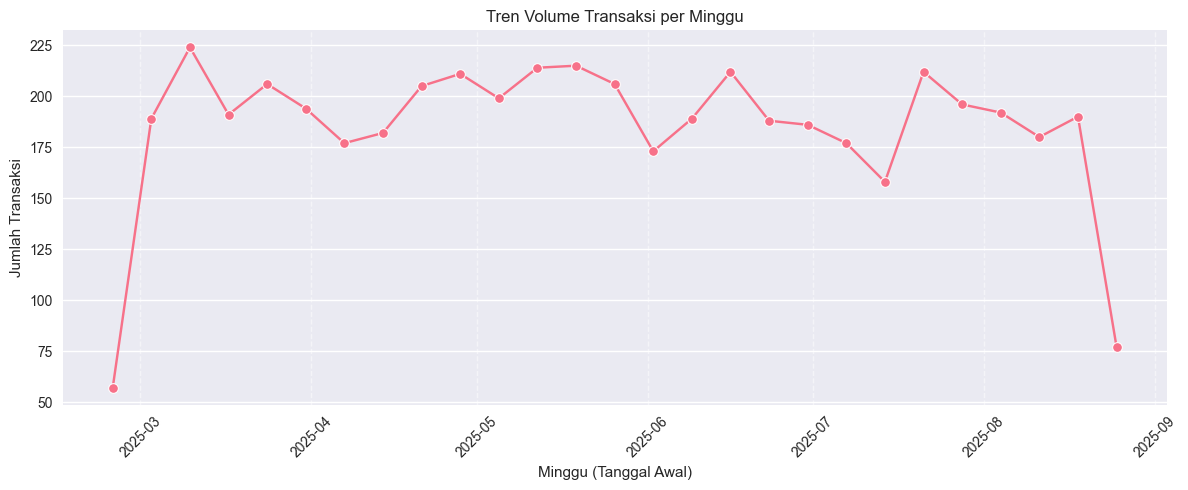

In [111]:
if 'transaction_date' in df.columns:
    df['week'] = df['transaction_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_trend = df.groupby('week').size()
    plt.figure(figsize=(12,5))
    sns.lineplot(x=weekly_trend.index, y=weekly_trend.values, marker='o')
    plt.title('Tren Volume Transaksi per Minggu')
    plt.xlabel('Minggu (Tanggal Awal)')
    plt.ylabel('Jumlah Transaksi')
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# kelompokkan pelanggan berdasarkan total belanja mereka

,segmen,total_belanja_rupiah
customer_name,,
Ahmad Fauzi,Medium Spender,Rp39.955.339.038
Andi Saputra,Medium Spender,Rp41.811.011.343
Budi Santoso,Low Spender,Rp39.110.081.111
Dewi Lestari,Low Spender,Rp35.708.429.405
Mega Putri,High Spender,Rp45.233.226.047
Nanda Pratama,High Spender,Rp42.757.076.014
Rudi Hartono,High Spender,Rp42.706.462.538
Siti Aminah,Low Spender,Rp38.261.531.088


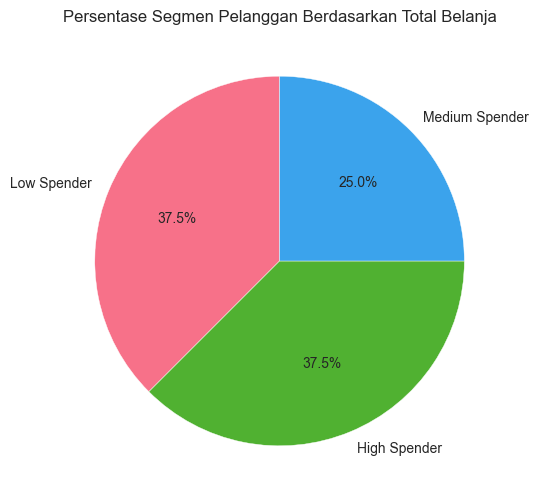

In [110]:
if 'customer_name' in df.columns and 'total_amount' in df.columns:
    total_belanja = df.groupby('customer_name')['total_amount'].sum()
    bins = [0, total_belanja.quantile(0.33), total_belanja.quantile(0.67), total_belanja.max()+1]
    labels = ['Low Spender', 'Medium Spender', 'High Spender']
    segmen = pd.cut(total_belanja, bins=bins, labels=labels, include_lowest=True)
    segmentasi = pd.DataFrame({'total_belanja': total_belanja, 'segmen': segmen})
    segmentasi['total_belanja_rupiah'] = segmentasi['total_belanja'].apply(lambda x: f"Rp{x:,.0f}".replace(",", "."))
    segmentasi = segmentasi.drop(columns=['total_belanja'])
    display(segmentasi)

    # Pie chart persentase segmen spender
    plt.figure(figsize=(6,6))
    segmentasi['segmen'].value_counts().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette("husl", 3),
        wedgeprops={'edgecolor': 'white'}
    )
    plt.title('Persentase Segmen Pelanggan Berdasarkan Total Belanja')
    plt.ylabel('')
    plt.show()

# 10% Pelanggan teratas menyumbang mayoritas revenue

In [112]:
if 'customer_name' in df.columns and 'total_amount' in df.columns:
    total_belanja = df.groupby('customer_name')['total_amount'].sum().sort_values(ascending=False)
    n_top = int(0.1 * len(total_belanja))
    top10 = total_belanja.head(n_top)
    total_revenue = total_belanja.sum()
    top10_revenue = top10.sum()
    prop_revenue = top10_revenue / total_revenue

    print(f"10% pelanggan teratas menyumbang {prop_revenue:.2%} dari total revenue.")
    print(f"Jumlah pelanggan: {len(total_belanja)}, 10% teratas: {n_top}")
    print(f"Total revenue: Rp{total_revenue:,.0f}".replace(",", "."))
    print(f"Revenue 10% teratas: Rp{top10_revenue:,.0f}".replace(",", "."))
    if prop_revenue >= 0.8:
        print("✓ Sesuai teori Pareto: 10% pelanggan teratas menyumbang mayoritas (>80%) revenue.")
    else:
        print("✗ Tidak sesuai teori Pareto: 10% pelanggan teratas belum menyumbang mayoritas revenue.")

10% pelanggan teratas menyumbang 0.00% dari total revenue.
Jumlah pelanggan: 8, 10% teratas: 0
Total revenue: Rp325.543.156.583
Revenue 10% teratas: Rp0
✗ Tidak sesuai teori Pareto: 10% pelanggan teratas belum menyumbang mayoritas revenue.
